In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb
import optuna
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [91]:
class CFG:
    target = "Calories"
    n_folds = 5
    seed = 42
    folder_path = 'playground-series-s5e5_csv/'

In [64]:
train = pd.read_csv(CFG.folder_path + 'train.csv')
test = pd.read_csv(CFG.folder_path + '/test.csv')
test['Calories'] = 0
train['is_train'] = 1
test['is_train'] = 0
datamart = pd.concat((train,test)).reset_index(drop=True)

gender_map = {'male':1,'female':0}
datamart['Sex'] = datamart['Sex'].map(gender_map)

# 1 Data overview

In [ ]:
# There are no missing values.
# Height min is 126...????
datamart.describe()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,is_train
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,499999.500000,0.498998,41.428419,174.704670,75.146179,15.419618,95.482767,40.036213,66.212086,0.750000
std,288675.278932,0.499999,15.175728,12.823881,13.981899,8.352851,9.449920,0.779518,66.190875,0.433013
min,0.000000,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,0.000000,0.000000
25%,249999.750000,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,0.750000,0.750000
50%,499999.500000,0.000000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,47.000000,1.000000
75%,749999.250000,1.000000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,113.000000,1.000000
max,999999.000000,1.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000,1.000000


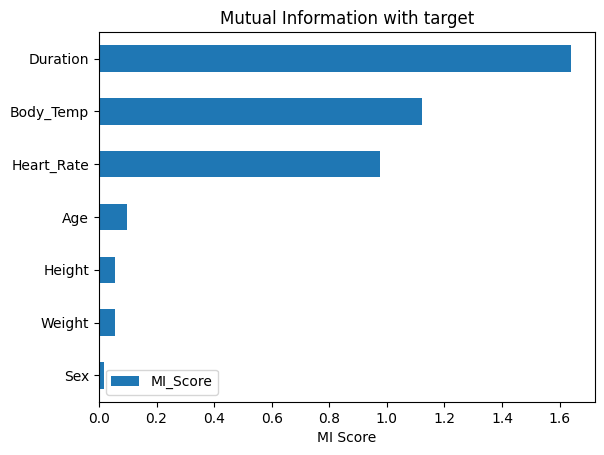

In [66]:
X = datamart[datamart['Calories'] > 0].drop(columns=["id","is_train","Calories"])
y = datamart[datamart['Calories'] > 0]["Calories"] 
mi = mutual_info_regression(X, y,random_state=CFG.seed)
mi = pd.Series(mi)
mi.index = X.columns
pd_mi = pd.DataFrame(mi.sort_values(ascending=False), columns=['MI_Score'])
pd_mi.plot.barh(title="Mutual Information with target")
plt.xlabel("MI Score")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
corr_data = datamart[datamart['is_train'] == 1][['Sex','Age','Height','Weight','Duration','Heart_Rate','Body_Temp','Calories']]
corr = corr_data.corr()
corr.style.background_gradient(cmap='coolwarm')

# Duration, Heart_rate ,Body_Temp(Body Temperature) has very high score

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
Sex,1.000000,0.009689,0.755906,0.818250,-0.009594,0.009122,-0.015933,0.012011
Age,0.009689,1.000000,0.011975,0.073690,0.015656,0.017037,0.030275,0.145683
Height,0.755906,0.011975,1.000000,0.957967,-0.029936,-0.013234,-0.034641,-0.004026
Weight,0.818250,0.073690,0.957967,1.000000,-0.020845,-0.002384,-0.023717,0.015863
Duration,-0.009594,0.015656,-0.029936,-0.020845,1.000000,0.875327,0.903066,0.959908
Heart_Rate,0.009122,0.017037,-0.013234,-0.002384,0.875327,1.000000,0.795972,0.908748
Body_Temp,-0.015933,0.030275,-0.034641,-0.023717,0.903066,0.795972,1.000000,0.828671
Calories,0.012011,0.145683,-0.004026,0.015863,0.959908,0.908748,0.828671,1.000000


# 2 Data Processing

In [69]:
datamart['Calories_Per_Minute'] = datamart['Calories']/datamart['Duration'].astype('float32')

# Calculate heart rate percentage based on HRmax
# Heart_Rate/(220-Age) * 100
# 50–60% HRmax: Light exercise (e.g., walking)
# 70–80% HRmax: Aerobic endurance training
# 85–95% HRmax: High-intensity interval training (HIIT)
datamart['HRP_based_HRmax'] = datamart['Heart_Rate']/(220-datamart['Age']) * 100

# Mifflin-St Jeor BMR calculation method
# for Man   : BMR = (10 × weight in kg)+(6.25 × height in cm)−(5 × age in years)+5
# for Woman : BMR = (10 × weight in kg)+(6.25 × height in cm)−(5 × age in years)−161
datamart['BMR'] = 10 * datamart['Weight'] + 6.25 * datamart['Height'] - 5 * datamart['Age'] + datamart['Sex'] * 166 - 161

In [74]:
train_X = datamart[datamart['Calories'] > 0].drop(columns=["id","is_train","Calories"])
train_y = datamart[datamart['Calories'] > 0]["Calories"] 

In [99]:
def rmsle(y_true, y_pred):
    y_true, y_pred = np.log1p(y_true), np.log1p(np.maximum(y_pred, 0))
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [101]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 5.0),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 20, 500),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 100),
        "random_state": 42,
        "early_stopping": True,
        "validation_fraction": 0.1,
        "n_iter_no_change": 10
    }

    model = HistGradientBoostingRegressor(**params)

    scores = cross_val_score(
        model, train_X, train_y,
        scoring=lambda m, X, y: np.sqrt(mean_squared_log_error(y, m.predict(X))),
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )

    return scores.mean()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)

# 결과 출력
print("Best RMSLE (negative):", study.best_value)
print("Best Params:", study.best_params)

[I 2025-05-10 17:45:38,768] A new study created in memory with name: no-name-ed157ae3-e919-4468-ba4a-79366c56f56c
[W 2025-05-10 17:46:00,483] Trial 0 failed with parameters: {'learning_rate': 0.09826654636463661, 'l2_regularization': 3.0761269281185024, 'max_depth': 19, 'max_features': 0.6461575458632971, 'max_iter': 140, 'max_leaf_nodes': 150, 'min_samples_leaf': 99} because of the following error: The value nan is not acceptable.
[W 2025-05-10 17:46:00,484] Trial 0 failed with value nan.
[W 2025-05-10 17:46:59,873] Trial 1 failed with parameters: {'learning_rate': 0.015477636339317164, 'l2_regularization': 2.0289756335890403, 'max_depth': 14, 'max_features': 0.4432861162454571, 'max_iter': 293, 'max_leaf_nodes': 259, 'min_samples_leaf': 39} because of the following error: The value nan is not acceptable.
[W 2025-05-10 17:46:59,874] Trial 1 failed with value nan.
[W 2025-05-10 17:49:04,698] Trial 2 failed with parameters: {'learning_rate': 0.01326379361098825, 'l2_regularization': 1.4

KeyboardInterrupt: 